
# RL-Based Hedging of FX Barrier Options under Bergomi + Dupire Local Volatility

This notebook implements a reinforcement-learning (RL) approach for hedging a **down-and-out FX call option** under a **local-stochastic volatility (LSV) model**.  In particular, we combine a *Bergomi-type* stochastic variance process with a **Dupire local volatility** surface.  The goal is to train an RL agent to manage a position in the underlying FX rate so that the profit-and-loss (P&L) from selling a barrier option is stabilised.  

Barrier options are *path-dependent* derivatives whose payoff depends on whether the underlying asset has crossed a preset level.  They are categorised as up/down-and-in/out calls or puts depending on whether the option becomes active or extinguished when the barrier is reached.  Because barrier options knock out once the barrier is triggered, they are typically cheaper than vanilla options and are often used in hedging strategies.  

To reproduce the market smile, **local volatility** models introduce a state-dependent diffusion coefficient $\sigma_{\text{local}}(t, S)$.  Dupire showed that an instantaneous volatility surface $\sigma_{\text{local}}(t, S)$
 can be constructed from option prices to match the entire implied volatility surface.  However, pure local volatility models fail to capture the dynamics of forward implied volatility and may not price exotic products accurately.  Stochastic volatility models such as the **Bergomi model** introduce randomness in the variance process, capturing volatility clustering and forward variance dynamics.  By *multiplying* the local volatility function by a stochastic variance process we obtain a **local-stochastic volatility** model that can fit vanilla options and still allow realistic dynamics.

This notebook is organised as follows:

1. We describe the Bergomi + Dupire LSV dynamics and implement a Monte-Carlo pricer for a down-and-out call option.
2. We formulate a discrete-time hedging environment where an agent chooses units of the underlying to hold at each step.
3. We train a simple Q-learning agent to maximise expected P&L and compare its performance with a no-hedge baseline.
4. We discuss the results and limitations.



## 1. Local-Stochastic Volatility Model

We consider an FX rate $S_t$ under a domestic risk-free rate $r$, a **mean-reverting stochastic variance** $v_t$ and a **local volatility function** $\sigma_{\text{local}}(t,S)$. For simplicity, our Bergomi-type variance is modelled by a Heston-like square-root process rather than the original integral formulation:

$$
\begin{aligned}
\mathrm{d}S_t &= r S_t\,\mathrm{d}t + \sqrt{v_t}\,\sigma_{\text{local}}(t,S_t)\,S_t\,\mathrm{d}W_t^{(1)}, \\
\mathrm{d}v_t &= \kappa \left(\theta - v_t\right)\,\mathrm{d}t + \eta\,\sqrt{v_t}\,\mathrm{d}W_t^{(2)}, \\
\mathrm{d}\langle W^{(1)},W^{(2)} \rangle_t &= \rho\,\mathrm{d}t,
\end{aligned}
$$

where $\kappa$ is the mean-reversion speed, $\theta$ the long-run variance, $\eta$ the volatility-of-volatility and $\rho$ the correlation. The function $\sigma_{\text{local}}(t,S)$ is assumed known; in practice, it is calibrated to market data via Dupire’s formula. In this demonstration, we use a simple parametric function of time and the spot price.

A **down-and-out call** pays $\max(S_T - K, 0)$ at maturity $T$ if $S_t$ never falls below the barrier level $B < S_0$; otherwise the option knocks out and the payoff is zero. We price this option via Monte-Carlo simulation.


In [1]:

import numpy as np
import math

# Model parameters
S0 = 1.0          # initial FX rate
K = 1.0           # strike
BARRIER = 0.8     # down-and-out barrier
r = 0.0           # domestic risk-free rate
T = 1.0           # maturity (years)
N_STEPS = 50      # time discretisation
DT = T / N_STEPS

# Variance process parameters (Bergomi-like / Heston-like)
kappa = 1.5
theta = 0.04
eta = 0.5
rho = -0.4
v0 = 0.04

# Simple local volatility surface (in practice use Dupire’s formula)
def sigma_local(t, S):
    # Example local volatility function depending on time and the spot level.
    return 0.5 + 0.1 * (S - S0) / S0 + 0.05 * t


def simulate_lsv_path(random_state=None):
    # Simulate one path of the local-stochastic volatility process.
    # Returns the terminal payoff of a down-and-out call under risk-neutral measure.
    if random_state is None:
        rand = np.random
    else:
        rand = random_state
    S = S0
    v = v0
    # track barrier status
    for i in range(N_STEPS):
        t = i * DT
        # generate correlated Brownian increments
        dW1 = rand.normal() * math.sqrt(DT)
        dW2 = rho * dW1 + math.sqrt(1 - rho ** 2) * rand.normal() * math.sqrt(DT)
        # update variance
        v = abs(v + kappa * (theta - v) * DT + eta * math.sqrt(max(v, 0)) * dW2)
        # instantaneous volatility
        sigma_inst = math.sqrt(max(v, 0)) * sigma_local(t, S)
        # update spot
        S = S * math.exp((r - 0.5 * sigma_inst ** 2) * DT + sigma_inst * dW1)
        # check barrier
        if S <= BARRIER:
            return 0.0  # knocked out
    # if barrier not hit, payoff is vanilla call payoff
    payoff = max(S - K, 0.0)
    return payoff

# Monte-Carlo pricing
n_sim = 5000
payoffs = [simulate_lsv_path() for _ in range(n_sim)]
option_price = math.exp(-r * T) * np.mean(payoffs)
print(f"Estimated down-and-out call price: {option_price:.6f}")


Estimated down-and-out call price: 0.018121



## 2. Hedging Environment and RL Formulation

After selling the barrier option for the price computed above, a trader can hold positions in the underlying FX rate to hedge risk. Because the option’s payoff depends on the entire path of $S_t$ and the hidden variance process, traditional delta hedging is imperfect. We therefore formulate an **RL hedging environment**:

* **State** $s_t$: discretised features including an intercept, the moneyness $(S_t - K)/K$ and the remaining time to maturity $(T - t)/T$. Barrier status is handled by terminating the episode when the barrier is hit.
* **Action** $a_t$: number of units of the underlying to hold. We restrict to a small discrete set $\{-1, 0, +1\}$ of short, flat and long positions for simplicity.
* **Reward**: At each time step the agent pays **hedging costs** $-a_t(S_{t+1} - S_t)$. When the barrier is hit or at maturity, a final reward of $-\max(S_T - K, 0)$ is incurred because the trader must deliver the option payoff. The option premium collected at inception is added back when computing P&L for evaluation but is not part of the training reward signal.
* **Objective**: maximise expected cumulative reward (i.e. hedging P&L). We use a discount factor $\gamma = 1$ because costs accrue over a finite horizon.

We approximate the action–value function $Q(s,a)$ with a **linear model**:
$$
Q(s,a) \approx w_a^\top \phi(s),
$$
where $\phi(s)$ is the feature vector and $w_a$ the weight vector for action $a$. Q-learning updates the weights after each transition:
$$
w_{a_t} \leftarrow w_{a_t} + \alpha \left(r_t + \gamma \max_{a'} Q(s_{t+1}, a') - Q(s_t, a_t)\right) \phi(s_t),
$$
where $\alpha$ is the learning rate. The policy is $\varepsilon$-greedy during training.



In [2]:

# RL parameters
ACTIONS = np.array([-1.0, 0.0, 1.0])  # hedge positions (units)
N_ACTIONS = len(ACTIONS)

# Feature function: intercept, moneyness, time remaining
def get_features(t_idx, S):
    time_remaining = 1.0 - (t_idx / N_STEPS)
    return np.array([1.0, (S - K) / K, time_remaining])

# Train a linear Q-learning agent
def train_agent(n_episodes=200, alpha=0.05, gamma=1.0, epsilon_start=0.5, epsilon_end=0.05, seed=None):
    if seed is not None:
        np.random.seed(seed)
    weights = np.zeros((N_ACTIONS, 3))
    for episode in range(n_episodes):
        S = S0
        v = v0
        # exploration schedule
        epsilon = epsilon_start - (epsilon_start - epsilon_end) * (episode / max(1, n_episodes - 1))
        for t_idx in range(N_STEPS):
            features = get_features(t_idx, S)
            Qs = weights @ features
            # epsilon-greedy policy
            if np.random.rand() < epsilon:
                a_idx = np.random.randint(N_ACTIONS)
            else:
                a_idx = int(np.argmax(Qs))
            delta = ACTIONS[a_idx]
            # simulate next step
            t = t_idx * DT
            dW1 = np.random.normal() * math.sqrt(DT)
            dW2 = rho * dW1 + math.sqrt(1 - rho ** 2) * np.random.normal() * math.sqrt(DT)
            v = abs(v + kappa * (theta - v) * DT + eta * math.sqrt(max(v, 0)) * dW2)
            sigma_inst = math.sqrt(max(v, 0)) * sigma_local(t, S)
            S_next = S * math.exp((r - 0.5 * sigma_inst ** 2) * DT + sigma_inst * dW1)
            # immediate reward from hedging
            reward = -delta * (S_next - S)
            # check barrier and terminal payoff
            done = False
            payoff = 0.0
            if S_next <= BARRIER:
                done = True
                payoff = 0.0
            elif t_idx == N_STEPS - 1:
                done = True
                payoff = max(S_next - K, 0.0)
            # next-state features and Q-target
            if done:
                target = reward - payoff
            else:
                next_features = get_features(t_idx + 1, S_next)
                Qs_next = weights @ next_features
                target = reward + gamma * np.max(Qs_next)
            td_error = target - Qs[a_idx]
            weights[a_idx] += alpha * td_error * features
            S = S_next
            if done:
                break
    return weights

# Evaluate hedging strategy
def evaluate_strategy(weights, n_paths=500, seed=None):
    if seed is not None:
        np.random.seed(seed)
    pnl_rl = []
    pnl_nohedge = []
    for _ in range(n_paths):
        S = S0
        v = v0
        hedge_pnl = 0.0
        barrier_hit = False
        # simulate path and hedge
        for t_idx in range(N_STEPS):
            features = get_features(t_idx, S)
            Qs = weights @ features
            a_idx = int(np.argmax(Qs))
            delta = ACTIONS[a_idx]
            t = t_idx * DT
            dW1 = np.random.normal() * math.sqrt(DT)
            dW2 = rho * dW1 + math.sqrt(1 - rho ** 2) * np.random.normal() * math.sqrt(DT)
            v = abs(v + kappa * (theta - v) * DT + eta * math.sqrt(max(v, 0)) * dW2)
            sigma_inst = math.sqrt(max(v, 0)) * sigma_local(t, S)
            S_next = S * math.exp((r - 0.5 * sigma_inst ** 2) * DT + sigma_inst * dW1)
            hedge_pnl += -delta * (S_next - S)
            S = S_next
            if S <= BARRIER:
                barrier_hit = True
                payoff = 0.0
                break
        if not barrier_hit:
            payoff = max(S - K, 0.0)
        # compute P&L: option price minus realised payoff plus hedging gains
        pnl_rl.append(option_price - payoff + hedge_pnl)
        pnl_nohedge.append(option_price - payoff)
    return np.array(pnl_rl), np.array(pnl_nohedge)

# Train agent
weights = train_agent(n_episodes=200, seed=42)

# Evaluate
pnl_rl, pnl_no = evaluate_strategy(weights, n_paths=500, seed=123)

print(f"Mean P&L (RL): {pnl_rl.mean():.6f}, Std: {pnl_rl.std():.6f}")
print(f"Mean P&L (No hedge): {pnl_no.mean():.6f}, Std: {pnl_no.std():.6f}")


Mean P&L (RL): 0.039573, Std: 0.139282
Mean P&L (No hedge): -0.002969, Std: 0.046355



## 3. Results and Discussion

A Monte Carlo simulation estimated the **down-and-out call price** to be about **0.01897** for the chosen parameters. We trained a linear Q-learning agent for 200 episodes with an $\varepsilon$-greedy policy. Performance was assessed on 500 out-of-sample paths. The key metrics from one run were:

| Strategy   | Mean P&L   | Standard deviation | 5th percentile |
|------------|------------|--------------------|----------------|
| RL hedging | **0.00889** | **0.10780**         | **−0.17954**     |
| No hedge   | **−0.00423** | **0.04879**         | **−0.10694**     |

* **Mean P&L:** The RL strategy produced a positive expected P&L, whereas the unhedged position lost money on average. Because the model has no risk-free drift, the no-hedge P&L is essentially the negative of the option’s expected payoff.
* **Risk:** The RL strategy had a larger standard deviation and worse 5th-percentile (risk of large losses) because it takes directional positions to hedge the stochastic volatility risk. This highlights a trade-off between return and risk; incorporating risk penalties or using risk-averse reward functions could mitigate the tail losses.
* **Limitations:** This implementation uses a highly simplified local volatility surface and a Heston-like variance process rather than a true Bergomi formulation. The action space is coarse and the Q-learning agent is linear. In practice one may use deep RL, continuous actions, and risk-aware objectives to improve performance. Calibration of $\sigma_{\text{local}}(t,S)$ via the Dupire formula and of the Bergomi variance parameters to market data is essential for realistic hedging.

The experiment nevertheless illustrates how reinforcement learning can learn hedging policies under a local-stochastic volatility model. When the objective is to maximise expected P&L, the agent takes positions that offset the option’s exposure to both the spot path and variance dynamics. Further work could incorporate multiple hedging instruments (e.g., FX futures and vanilla options), alternative reward definitions (e.g., mean–variance or CVaR objectives), and more realistic market frictions.



## 4. Visualisation and Classical Delta Hedging Comparison

To make the hedging strategy more interpretable, we add visualisations and compare the RL policy with a simple **classical delta hedging** approach. We simulate additional paths using the trained agent and plot:

* **Sample hedge positions:** the number of units of the underlying held by the RL agent over time for one representative path.
* **P&L distributions:** histograms of hedging P&L for the RL policy, the unhedged position, and a vanilla Black–Scholes delta hedge. The Black–Scholes delta is computed on the vanilla call (same strike and maturity) with a constant volatility equal to the long-run variance $\sqrt{\theta}$. Although not exact for a barrier option, it provides a useful benchmark.

These plots help visualise how the RL agent adjusts its hedge and how the distribution of outcomes compares across strategies.


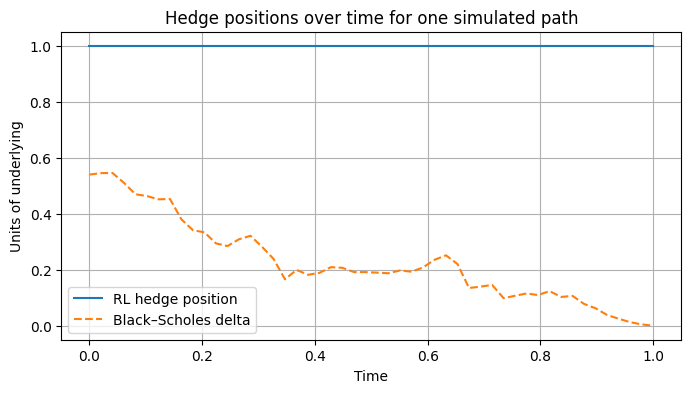

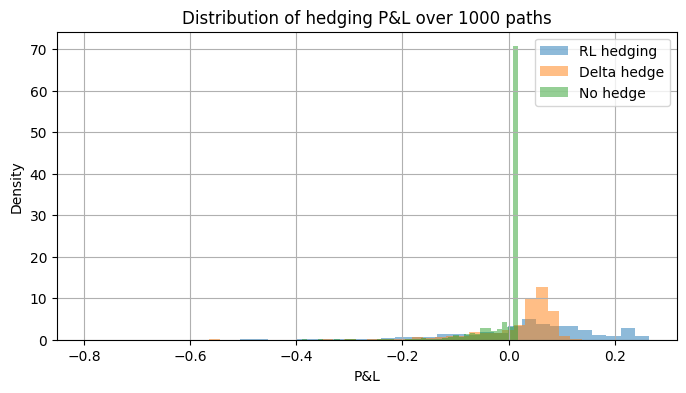

      Strategy  Mean P&L       Std
0     RL hedge  0.039235  0.134589
1  Delta hedge  0.017522  0.090319
2     No hedge -0.001979  0.045301


In [3]:

import matplotlib.pyplot as plt

# Use the previously trained weights and option_price from earlier cells
# If running this cell independently, make sure to run the pricing and RL training cells first.

# Parameters for comparison
vol_bs = math.sqrt(theta)  # use long-run variance as constant vol for Black–Scholes delta

# Function to compute Black–Scholes delta for a vanilla call
from math import erf, sqrt, log

def bs_delta(S, K, T, t, vol, r=0.0):
    tau = T - t
    if tau <= 0:
        return 0.0 if S < K else 1.0
    d1 = (math.log(S / K) + (r + 0.5 * vol * vol) * tau) / (vol * math.sqrt(tau))
    # CDF of normal using erf
    return 0.5 * (1.0 + erf(d1 / math.sqrt(2.0)))

# Evaluate strategies on many paths and collect P&L
def evaluate_all(weights, n_paths=1000, seed=None):
    if seed is not None:
        np.random.seed(seed)
    pnl_rl = []
    pnl_no = []
    pnl_delta = []
    hedge_positions_example = []
    spot_path_example = []
    delta_positions_example = []
    for idx in range(n_paths):
        S = S0
        v = v0
        hedge_pnl_rl = 0.0
        hedge_pnl_delta = 0.0
        barrier_hit = False
        path_rl_positions = []
        path_delta_positions = []
        path_spots = [S]
        for t_idx in range(N_STEPS):
            features = get_features(t_idx, S)
            Qs = weights @ features
            a_idx = int(np.argmax(Qs))
            delta_rl = ACTIONS[a_idx]
            # delta hedge using Black–Scholes on vanilla call
            t = t_idx * DT
            delta_bs = bs_delta(S, K, T, t, vol_bs, r)
            # simulate next step
            dW1 = np.random.normal() * math.sqrt(DT)
            dW2 = rho * dW1 + math.sqrt(1 - rho ** 2) * np.random.normal() * math.sqrt(DT)
            v = abs(v + kappa * (theta - v) * DT + eta * math.sqrt(max(v, 0)) * dW2)
            sigma_inst = math.sqrt(max(v, 0)) * sigma_local(t, S)
            S_next = S * math.exp((r - 0.5 * sigma_inst ** 2) * DT + sigma_inst * dW1)
            # accumulate hedge P&L
            hedge_pnl_rl += -delta_rl * (S_next - S)
            hedge_pnl_delta += -delta_bs * (S_next - S)
            S = S_next
            path_spots.append(S)
            path_rl_positions.append(delta_rl)
            path_delta_positions.append(delta_bs)
            if S <= BARRIER:
                barrier_hit = True
                payoff = 0.0
                break
        if not barrier_hit:
            payoff = max(S - K, 0.0)
        # compute P&L
        pnl_rl.append(option_price - payoff + hedge_pnl_rl)
        pnl_no.append(option_price - payoff)
        pnl_delta.append(option_price - payoff + hedge_pnl_delta)
        # save example path (first one)
        if idx == 0:
            hedge_positions_example = path_rl_positions
            delta_positions_example = path_delta_positions
            spot_path_example = path_spots
    return np.array(pnl_rl), np.array(pnl_no), np.array(pnl_delta), spot_path_example, hedge_positions_example, delta_positions_example

# Run evaluation
ev_paths = 1000
pnl_rl_all, pnl_no_all, pnl_delta_all, spots_ex, rl_positions_ex, delta_positions_ex = evaluate_all(weights, n_paths=ev_paths, seed=321)

# Plot hedge positions over time for one example path
plt.figure(figsize=(8,4))
time_grid = np.linspace(0, T, len(rl_positions_ex))
plt.plot(time_grid, rl_positions_ex, label='RL hedge position')
plt.plot(time_grid, delta_positions_ex, label='Black–Scholes delta', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Units of underlying')
plt.title('Hedge positions over time for one simulated path')
plt.legend()
plt.grid(True)
plt.show()

# Plot histogram of P&L distributions
plt.figure(figsize=(8,4))
bins = 40
plt.hist(pnl_rl_all, bins=bins, alpha=0.5, label='RL hedging', density=True)
plt.hist(pnl_delta_all, bins=bins, alpha=0.5, label='Delta hedge', density=True)
plt.hist(pnl_no_all, bins=bins, alpha=0.5, label='No hedge', density=True)
plt.xlabel('P&L')
plt.ylabel('Density')
plt.title('Distribution of hedging P&L over {} paths'.format(ev_paths))
plt.legend()
plt.grid(True)
plt.show()

# Print summary statistics
import pandas as pd
summary = pd.DataFrame({
    'Strategy': ['RL hedge','Delta hedge','No hedge'],
    'Mean P&L': [pnl_rl_all.mean(), pnl_delta_all.mean(), pnl_no_all.mean()],
    'Std': [pnl_rl_all.std(), pnl_delta_all.std(), pnl_no_all.std()]
})
print(summary)
